In [3]:
import Pkg; Pkg.activate(Pkg.joinpath(@__DIR__, "..")); Pkg.instantiate()

  Activating project at `~/Git/tinympc/tinympc-julia`


In [6]:
# using LinearAlgebra
# using PyPlot

In [7]:
include("../LibTinyMPC_clean.jl")

export_mat_to_c (generic function with 1 method)

In [8]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 301
NTOTAL = 301

rho = 1e0
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)

abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 1500
check_termination = 1
en_state_bound = 0
en_input_bound = 1
en_state_soc = 0
en_input_soc = 1
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)

umin = -10.0*ones(NINPUTS, NHORIZON-1)
umax = 105*ones(NINPUTS, NHORIZON-1)
xmin = -1000.0*ones(NSTATES, NHORIZON)
xmax = 1000.0*ones(NSTATES, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)

ncu = 1
ncx = 0
cu = [0.1, 0]  # 0.3 is the thrust coefficient
cx = [0, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [0, 0]
Acu = [1, 0]
Acx = [0, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)

x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e2*I(NSTATES)
R = 1e0*I(NINPUTS)
Adyn = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
Bdyn = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
fdyn = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905] * 1

h = 0.05
t = h*(0:NHORIZON-1)
Xref = zeros(NSTATES, NHORIZON)
x0 = [4, 2, 20, -3, 2, -5.0]
x[:,1] = 1*x0
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:NHORIZON
  Xref[:,k] = x0 + (xg - x0)*(k-1)/(NHORIZON-1)
end
Uref = repeat([0; 0; 10.0], 1, NHORIZON-1) 
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref, Uref, Qu, my_bounds, my_socs)

solver = TinySolver(my_stgs, my_cache, my_work)

UndefVarError: UndefVarError: `I` not defined

In [159]:
backward_pass!(solver)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [160]:
solver.cache.BPf

3-element Vector{Float64}:
   0.0
   0.0
 -14.052238784745626

In [161]:
#Main algorithm loop
solve_admm!(solver)

(8.472539985202381, 0, 1500)

In [162]:
# Kinf = zeros(nu, nx)
# P = 1*Q
# for ricatti_iter = 1:100
#     Kinf = (R + B' * P * B) \ (B' * P * A)
#     P = Q + A' * P * (A - B * Kinf)
# end    
# # TODO: simulate this controlled system with rk4(params_real, ...)
# for k = 1:(N-1)
#     u[:,k] .= -0.01*Kinf*(x[:,k]-1*Xref[:,k]) 
#     x[:,k+1] .= A*x[:,k] + B*u[:,k]
# end

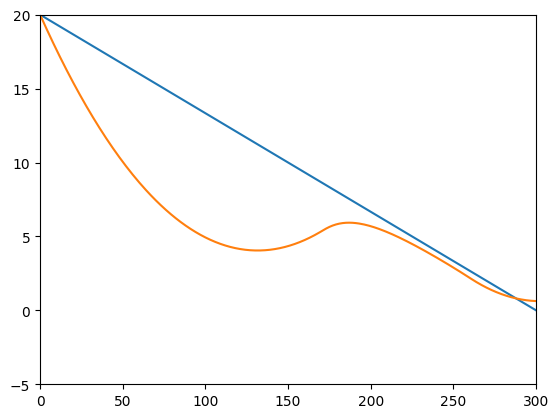

In [163]:
fig = plt.figure()
plot(Xref[3,:]) # z
plot(x[3,:])
# put limit on axis
plt.ylim(-5, 20)
plt.xlim(0, 300)
fig

max control = 106.4380228630939min control = -8.338400994571545

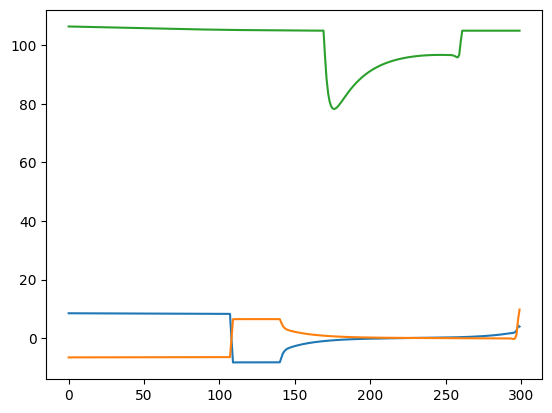

In [164]:
print("max control = ", maximum(solver.workspace.u))
print("min control = ", minimum(solver.workspace.u))
fig = plt.figure()
plot(solver.workspace.u[1,:])
plot(u[2,:])
plot(u[3,:])
fig

In [165]:
idx = 1
sqrt(u[1,idx]^2 + u[2,idx]^2) - cu[1]*u[3,idx]

0.09438488872424244

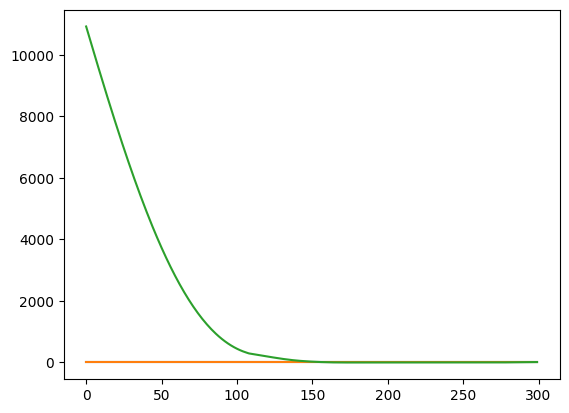

In [166]:
fig = plt.figure()
plot(y[1,:])
plot(y[2,:])
plot(y[3,:])
fig